In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [1]:
#Initialising Hyper Parameters

#Uncomment one of the two below lines. For some reason, on some computers the first one works, while on others the second.
from tensorflow.keras.optimizers import Adam
#from keras.optimizers import adam
import tensorflow as tf

import numpy as np
import keras

np.random.seed(10)  #for consistency of random numbers and our images

noise_dim = 100  # input dimension of random vector - the vector that goes into the generator

batch_size = 128   #How many images do we want to include in each batch
steps_per_epoch = 2500  #How many steps do we want to take per iteration of our training set (number of batches)
epochs = 30      #How many iterations of our training set do we want to do.

#change the below values to the dimensions of your image. The channels number refers to the number of colors
img_rows, img_cols, channels = 128, 128, 4

#These are the recommended values for the optimizer
optimizer = Adam(0.0002, 0.5)

In [ ]:
from keras.initializers import RandomNormal
from keras.layers import Dense, Conv2D, Conv2DTranspose, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential


def create_generator_cgan():
    generator = Sequential()
    
    d = 32
    generator.add(Dense(d*d*256, kernel_initializer=RandomNormal(0, 0.02), input_dim=noise_dim))
    generator.add(LeakyReLU(0.2))     #We are going to use the same leaky relu activation function as the FCGAN.
    
    generator.add(Reshape((d, d, 256)))
    
    generator.add(Conv2DTranspose(128, (4, 4), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    generator.add(LeakyReLU(0.2))

    generator.add(Conv2DTranspose(128, (4, 4), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    generator.add(LeakyReLU(0.2))
    

    
    generator.add(Conv2D(channels, (3, 3), padding='same', activation='tanh', kernel_initializer=RandomNormal(0, 0.02)))  #Remember that the final activation has to be tanh, since pixel values go from -1 to 1
    
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)    #The loss doesn't change when you use convolutional layers
    return generator

In [ ]:
a=create_generator_cgan()
a.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 262144)            26476544  
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 262144)            0         
                                                                 
 reshape_2 (Reshape)         (None, 32, 32, 256)       0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 64, 64, 128)      524416    
 ranspose)                                                       
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 64, 64, 128)       0         
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 128, 128, 128)    262272    
 ranspose)                                            

In [ ]:
from keras.initializers import RandomNormal
from keras.layers import Dense, Conv2D, Flatten, Reshape, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential

def create_discriminator_cgan():
    discriminator = Sequential()
    
    discriminator.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=RandomNormal(0, 0.02), input_shape=(img_cols, img_rows, channels)))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Conv2D(128, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Conv2D(128, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Conv2D(256, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Flatten())
    discriminator.add(Dropout(0.4))
    discriminator.add(Dense(1, activation='sigmoid', input_shape=(img_cols, img_rows, channels)))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)  #Again, the loss doesn't change when creating a DCGAN.
    return discriminator

In [ ]:
a=create_discriminator_cgan()

In [ ]:
a.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 128, 128, 64)      2368      
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 128, 128, 64)      0         
                                                                 
 conv2d_12 (Conv2D)          (None, 64, 64, 128)       73856     
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 64, 64, 128)       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 128)       147584    
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 32, 32, 128)       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 16, 16, 256)      

In [ ]:
from keras.layers import Input
from keras.models import Model

discriminator = create_discriminator_cgan()
generator = create_generator_cgan()

discriminator.trainable = False

gan_input = Input(shape=(noise_dim,))
fake_image = generator(gan_input)

gan_output = discriminator(fake_image)

gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=optimizer)

In [ ]:
import numpy as np
arr=np.load('C:/Users/guest/Downloads/asad_gan_code/numpy_array.npy')

In [ ]:
arr.shape

(5134, 128, 128)

In [ ]:
import tensorflow as tf
x_cat=tf.keras.utils.to_categorical(arr, num_classes=None, dtype='float32')

In [ ]:
a.shape

(128, 128, 4)

In [ ]:
np.unique(a)

array([0., 1.], dtype=float32)

In [ ]:
import matplotlib.pyplot as plt
def show_images(noise, size_fig):
    generated_images = generator.predict(noise)   #Create the images from the GAN.
    generated_images=np.argmax(generated_images,axis=3)
    plt.figure(figsize=size_fig)
    
    for i, image in enumerate(generated_images):
        plt.subplot(size_fig[0], size_fig[1], i+1)
        if channels == 1:
            plt.imshow(image.reshape((img_rows, img_cols)))    #If the image is grayscale, as in our case, then we will reshape the output in the following way.
                                                                            #Also, we set the coloring to grayscale so that it doesn't look like it came out of an infrared camera :)
        else:
            plt.imshow(image.reshape((img_rows, img_cols)))
        plt.axis('off')
    
    plt.tight_layout()   #Tight layout so that all of the generated images form a nice grid
    plt.show()

In [ ]:
path_discrim='C:\Users\guest\Downloads\asad_gan_code\model_saved\discrimntor\'
path_generator='C:\Users\guest\Downloads\asad_gan_code\model_saved\full\'
path_gan='C:\Users\guest\Downloads\asad_gan_code\model_saved\generator\'

Epoch: 1 	 Discriminator Loss: 0.2284058779478073 		 Generator Loss: 4.277570724487305


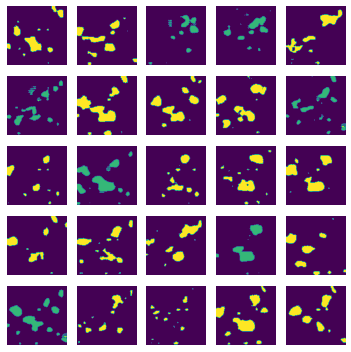

Epoch: 2 	 Discriminator Loss: 0.17780394852161407 		 Generator Loss: 4.940126419067383


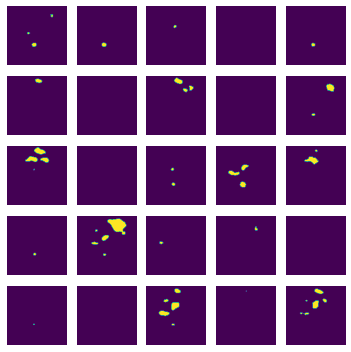

Epoch: 3 	 Discriminator Loss: 0.5835976600646973 		 Generator Loss: 3.5096681118011475


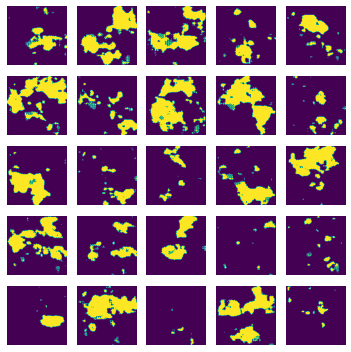

Epoch: 4 	 Discriminator Loss: 0.16780412197113037 		 Generator Loss: 6.124262809753418


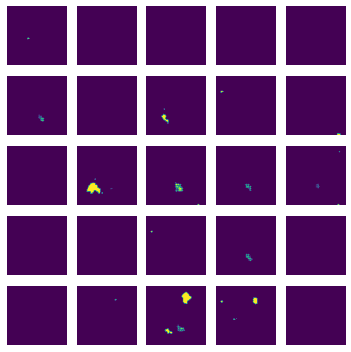

Epoch: 5 	 Discriminator Loss: 0.18270163238048553 		 Generator Loss: 5.0822529792785645


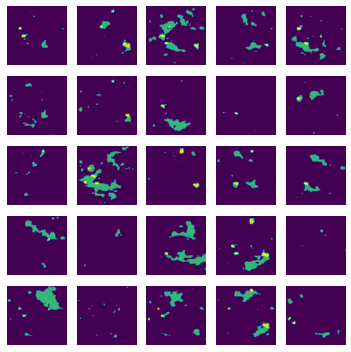

Epoch: 6 	 Discriminator Loss: 0.17384126782417297 		 Generator Loss: 5.380708694458008


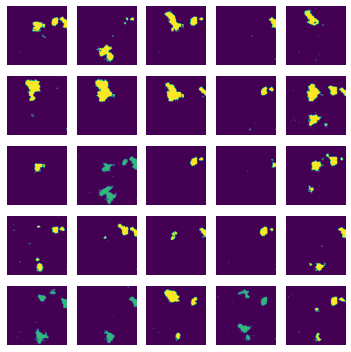

Epoch: 7 	 Discriminator Loss: 0.17017225921154022 		 Generator Loss: 6.0873517990112305


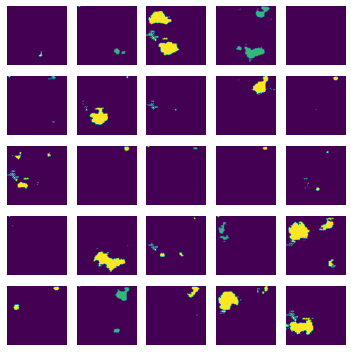

Epoch: 8 	 Discriminator Loss: 0.16844488680362701 		 Generator Loss: 6.219493865966797


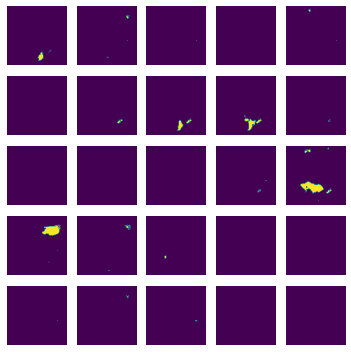

Epoch: 9 	 Discriminator Loss: 0.1881803721189499 		 Generator Loss: 4.761370658874512


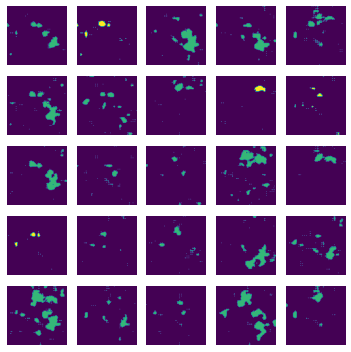

Epoch: 10 	 Discriminator Loss: 0.1698753982782364 		 Generator Loss: 6.236850261688232


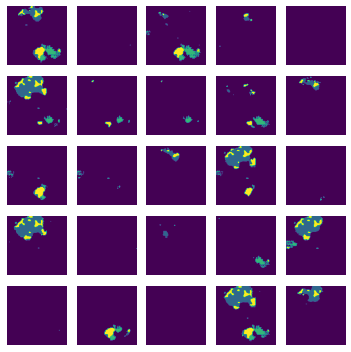

Epoch: 11 	 Discriminator Loss: 0.17550505697727203 		 Generator Loss: 5.83110237121582


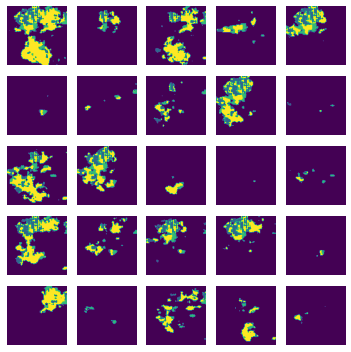

Epoch: 12 	 Discriminator Loss: 0.16718317568302155 		 Generator Loss: 6.580989837646484


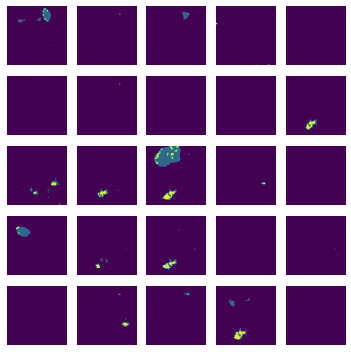

Epoch: 13 	 Discriminator Loss: 0.1742073893547058 		 Generator Loss: 5.275540351867676


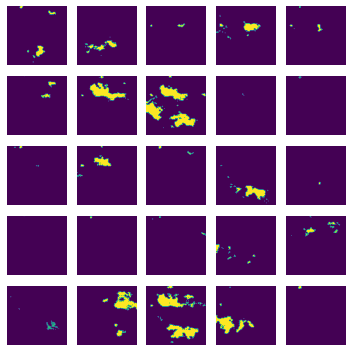

Epoch: 14 	 Discriminator Loss: 0.16523286700248718 		 Generator Loss: 8.418059349060059


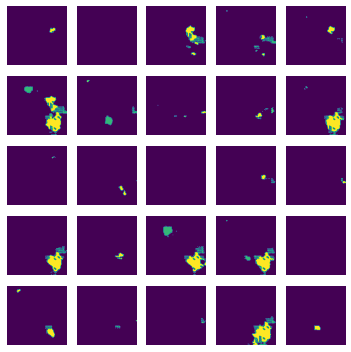

Epoch: 15 	 Discriminator Loss: 0.18966467678546906 		 Generator Loss: 4.604697227478027


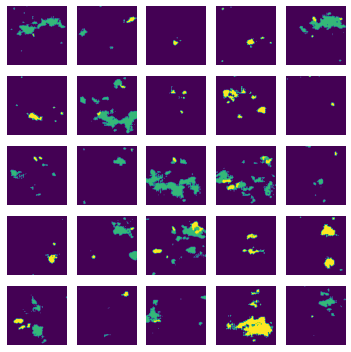

Epoch: 16 	 Discriminator Loss: 0.17526064813137054 		 Generator Loss: 5.078627586364746


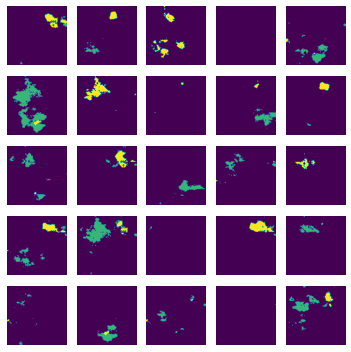

Epoch: 17 	 Discriminator Loss: 0.16547249257564545 		 Generator Loss: 6.551657676696777


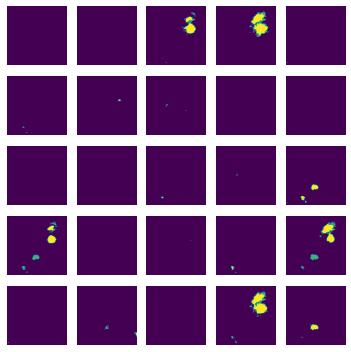

Epoch: 18 	 Discriminator Loss: 0.16849085688591003 		 Generator Loss: 7.142561912536621


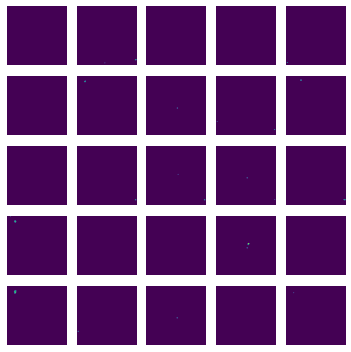

Epoch: 19 	 Discriminator Loss: 0.17455512285232544 		 Generator Loss: 5.464742183685303


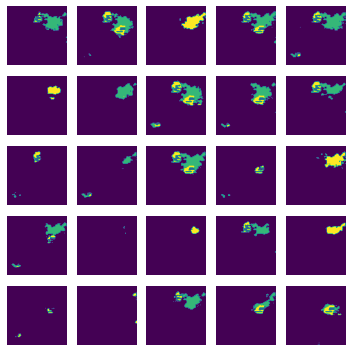

Epoch: 20 	 Discriminator Loss: 0.1669318825006485 		 Generator Loss: 7.15003776550293


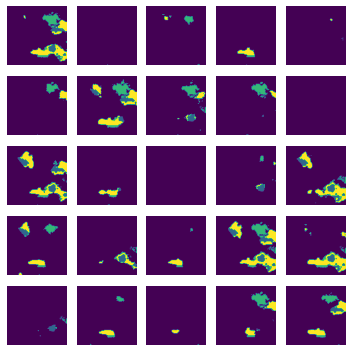

Epoch: 21 	 Discriminator Loss: 0.16655831038951874 		 Generator Loss: 6.329655647277832


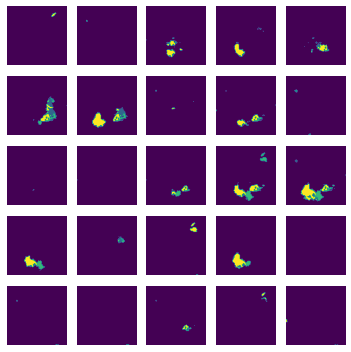

Epoch: 22 	 Discriminator Loss: 0.16616825759410858 		 Generator Loss: 6.485409259796143


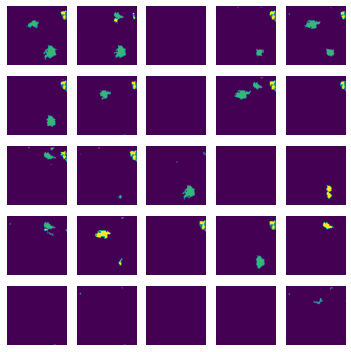

Epoch: 23 	 Discriminator Loss: 0.19572794437408447 		 Generator Loss: 3.811923027038574


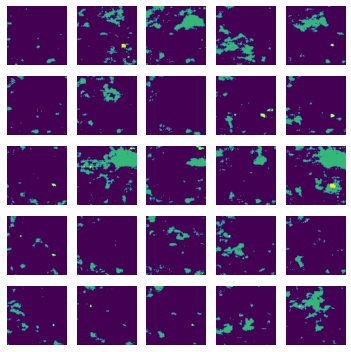

Epoch: 24 	 Discriminator Loss: 0.17125000059604645 		 Generator Loss: 6.268176078796387


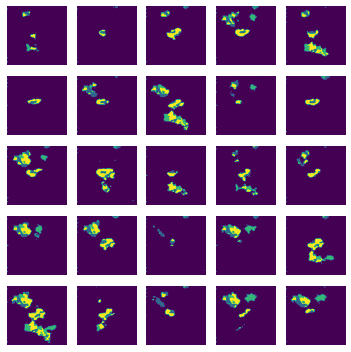

Epoch: 25 	 Discriminator Loss: 0.16431210935115814 		 Generator Loss: 8.079195022583008


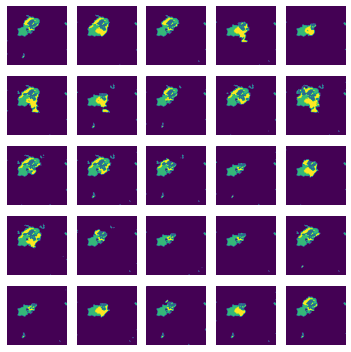

Epoch: 26 	 Discriminator Loss: 0.1713259518146515 		 Generator Loss: 5.756694316864014


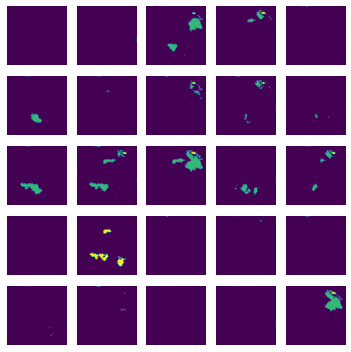

Epoch: 27 	 Discriminator Loss: 0.17125125229358673 		 Generator Loss: 6.1613569259643555


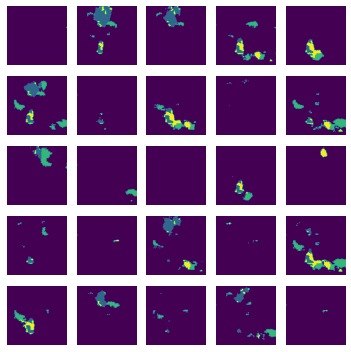

Epoch: 28 	 Discriminator Loss: 0.16646328568458557 		 Generator Loss: 6.774783611297607


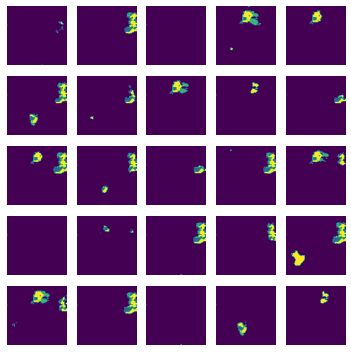

Epoch: 29 	 Discriminator Loss: 0.18750832974910736 		 Generator Loss: 5.3150835037231445


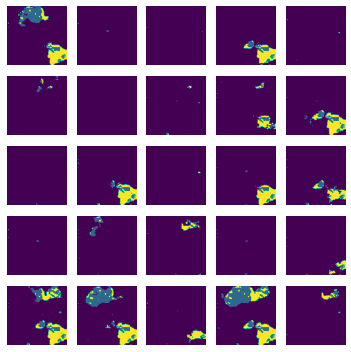

Epoch: 30 	 Discriminator Loss: 0.17142686247825623 		 Generator Loss: 5.600095748901367


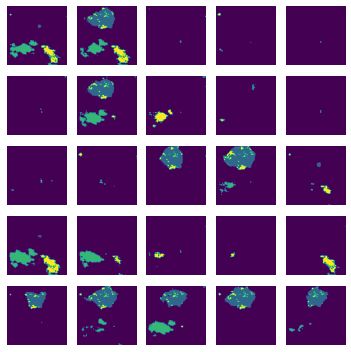

INFO:tensorflow:Assets written to: /content/drive/MyDrive/brain tumor segmentation/GANS/asad data/saved models /epoch 60/generator/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/brain tumor segmentation/GANS/asad data/saved models /epoch 60/full model/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/brain tumor segmentation/GANS/asad data/saved models /epoch 60/discrimator/assets


In [ ]:
for epoch in range(epochs):
    for batch in range(steps_per_epoch):
        noise = np.random.normal(0, 1, size=(batch_size, noise_dim))
        fake_x = generator.predict(noise)

        real_x = x_cat[np.random.randint(0, x_cat.shape[0], size=batch_size)]###check this line  and its value in the first dimensions
        #print(real_x.shape)
        #print(fake_x.shape)
        x = np.concatenate((real_x, fake_x))

        disc_y = np.zeros(2*batch_size)
        disc_y[:batch_size] = 0.9

        d_loss = discriminator.train_on_batch(x, disc_y)

        y_gen = np.ones(batch_size)
        g_loss = gan.train_on_batch(noise, y_gen)

    print(f'Epoch: {epoch + 1} \t Discriminator Loss: {d_loss} \t\t Generator Loss: {g_loss}')
    noise = np.random.normal(0, 1, size=(25, noise_dim))
    show_images(noise, (5, 5))

##saving model    
generator.save(path_generator)
gan.save(path_gan)
discriminator.save(path_discrim)

In [1]:
!pip list


Package                       Version
----------------------------- --------------
absl-py                       0.12.0
alabaster                     0.7.12
albumentations                0.1.12
altair                        4.1.0
appdirs                       1.4.4
argcomplete                   1.12.3
argon2-cffi                   21.1.0
arviz                         0.11.4
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
atari-py                      0.2.9
atomicwrites                  1.4.0
attrs                         21.2.0
audioread                     2.1.9
autograd                      1.3
Babel                         2.9.1
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        4.1.0
blis                          0.4.1
bokeh                         2.3.3
Bottleneck                    1.3.2
branca                        0.4.2
bs4                           0.0.1
CacheControl

In [3]:
!python --version


Python 3.7.12
